In [3]:
!pip install torch torchvision






  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/aa/3f/85b56f7e2abcfa558c5fbf7b11eb02d78a4a63e6aeee2bbae3bb552abea5/torch-2.7.0-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/b1/43/28bc858b022f6337326d75f4027d2073aad5432328f01ee1236d847f1b82/torchvision-0.22.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.10.0 from https://files.pythonhosted.org/packages/8b/54/b1ae86c0973cc6f0210b53d508ca3641fb6d0c56823f288d108bc7ab3cc8/typing_extensions-4.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 21.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
print(torch.__version__)



2.7.0


In [5]:
# satellite_classification.py

import torch
import torchvision.transforms as transforms
from torchvision.datasets import EuroSAT
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load Dataset
train_dataset = EuroSAT(root='data/', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define CNN
class SatelliteCNN(nn.Module):
    def __init__(self):
        super(SatelliteCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SatelliteCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
for epoch in range(5):  # 5 epochs for demo
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

print("Finished Training")


100%|██████████████████████████████████████| 94.3M/94.3M [00:05<00:00, 17.2MB/s]


Epoch 1, Loss: 1.2215385814131154
Epoch 2, Loss: 0.794398673832134
Epoch 3, Loss: 0.6766741188216548
Epoch 4, Loss: 0.6126540456479195
Epoch 5, Loss: 0.5542734251909346
Finished Training


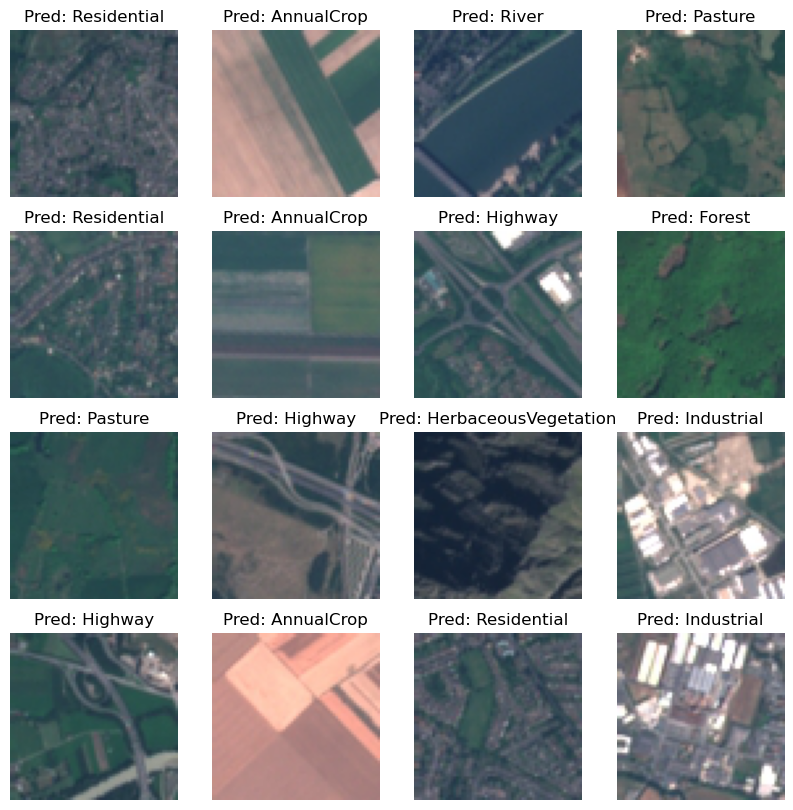

In [6]:
import matplotlib.pyplot as plt
import numpy as np

classes = train_dataset.classes
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Get prediction
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Plot images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"Pred: {classes[predicted[i]]}")
    ax.axis('off')
plt.show()
